In [1]:
%load_ext autoreload
%autoreload 2
import stim
import numpy as np
import matplotlib.pyplot as plt
import sinter
from typing import List
import surface_general_defect
from surface_general_defect import LogicalQubit

In [36]:
DEPOL1 = 0.0005
DEPOL2 = 0.003
READOUT_ERR = 0.001

def gen_circuit_with_deforms(d, r, missing_coords):
    # error probs aren't the point
    logical_qubit = surface_general_defect.LogicalQubit(d, READOUT_ERR, DEPOL1, DEPOL2, missing_coords=missing_coords, get_metrics=True)
    if len(logical_qubit.defect) == 0:
        circuit = logical_qubit.generate_stim(r)
    else:
        circuit = logical_qubit.generate_stim_shell(r)
    return logical_qubit, circuit

In [3]:
def gen_stim_file(d, r, missing_coords, folder=None, fname=None):
    if missing_coords is None:
        missing_coords = []
    if folder is None:
        folder = "."
    if fname is None:
        fname = f"surface_d{d}r{r}_cut{len(missing_coords)}.stim"
    file = f"{folder}/{fname}"
    print(fname)
    
    logical_qubit, circuit = gen_circuit_with_deforms(d, r, missing_coords)

    import os
    os.makedirs(folder, exist_ok=True)
    circuit.to_file(file)

In [9]:
import os
from pathlib import Path
from typing import List, Tuple

# ----------------- config -----------------
d = 9
r = 3 * d
OUT = Path(f"stim_circuits_d{d}_centerline_spaced")
OUT.mkdir(parents=True, exist_ok=True)

# ----------------- helpers -----------------
from typing import List, Tuple

def spaced_centerline_positions(d: int, start_y: int = 0, step: int = 4, max_y: int = 16) -> List[List[Tuple[int, int]]]:
    """
    Returns a list of *lists* of defect coordinates along the center/right line,
    each list adding one more defect (non-adjacent, spacing >= step).

    Example (d=9):
    [
      [(8, 0)],
      [(8, 0), (8, 4)],
      [(8, 0), (8, 4), (8, 8)],
      [(8, 0), (8, 4), (8, 8), (8, 12)],
      [(8, 0), (8, 4), (8, 8), (8, 12), (8, 16)]
    ]
    """
    x = d - 1
    if x % 2 != 0:
        raise ValueError(f"d-1 must be even for data-qubit coords; got d={d}")

    # All candidate y positions (even, spaced by >= step)
    ys = list(range(start_y, max_y + 1, step))
    all_positions = [(x, y) for y in ys]

    # Build progressive lists
    progressive_sets: List[List[Tuple[int, int]]] = []
    for i in range(1, len(all_positions) + 1):
        subset = all_positions[:i]
        progressive_sets.append(subset)

    return progressive_sets


# ----------------- filenames -----------------
def fname_defect(x: int, y: int, dist: int) -> str:
    return f"d{d}_r{r}_defect_x{x}_y{y}_edgeDist{dist}.stim"

def fname_baseline() -> str:
    return f"d{d}_r{r}_defect_none_edgeDist0.stim"


In [17]:
# ----------------- generate (track ndefects) -----------------
generated = []

def fname_baseline() -> str:
    return f"d{d}_r{r}_ndefects0_baseline.stim"

def fname_defects(ndefects: int) -> str:
    # e.g., d9_r27_ndefects3.stim
    return f"d{d}_r{r}_ndefects{ndefects}.stim"

# Baseline (no defect)
baseline_name = fname_baseline()
gen_stim_file(d, r, missing_coords=[], folder=str(OUT), fname=baseline_name)  # your function writes to OUT
generated.append({
    "path": OUT / baseline_name,
    "series": "baseline",
    "ndefects": 0,
    "missing_coords": [],
})

# Progressive defect sets along center line (non-adjacent by >= 4 in y)
for missing_coords in spaced_centerline_positions(d, start_y=0, step=4, max_y=16):
    ndef = len(missing_coords)
    name = fname_defects(ndef)
    gen_stim_file(d, r, missing_coords=missing_coords, folder=str(OUT), fname=name)
    generated.append({
        "path": OUT / name,
        "series": "defect",
        "ndefects": ndef,
        "missing_coords": missing_coords[:],  # keep for reference/debug
    })

print("Generated:")
for g in generated:
    print(f"{g['series']:8s}  ndefects={g['ndefects']:2d}  -> {g['path'].name}")


d9_r27_ndefects0_baseline.stim
d9_r27_ndefects1.stim
d9_r27_ndefects2.stim
d9_r27_ndefects3.stim
d9_r27_ndefects4.stim
d9_r27_ndefects5.stim
Generated:
baseline  ndefects= 0  -> d9_r27_ndefects0_baseline.stim
defect    ndefects= 1  -> d9_r27_ndefects1.stim
defect    ndefects= 2  -> d9_r27_ndefects2.stim
defect    ndefects= 3  -> d9_r27_ndefects3.stim
defect    ndefects= 4  -> d9_r27_ndefects4.stim
defect    ndefects= 5  -> d9_r27_ndefects5.stim


In [39]:
import subprocess
from pathlib import Path
import stim, sinter, matplotlib.pyplot as plt, os

CPP_BIN = Path("../cpp/build/superstabilizer_splicing").resolve()
OUT_DIR = Path(".")

def ent_name(p: Path) -> Path:
    return p.with_name(p.stem + "_ent.stim")

# Build initial task list (baseline + defects) from `generated`
# generated entries look like:
#   {"path": OUT / name, "series": "baseline"/"defect", "ndefects": int, "missing_coords": [...]}

# --- run C++ pass and append *-ent entries
gen_with_ent = list(generated)  # copy
for g in generated:
    inp = g["path"]
    assert inp.exists(), f"Missing: {inp}"
    # Run from the folder containing the input, pass basename (avoids cwd surprises)
    res = subprocess.run(
        [str(CPP_BIN), "-o", str(OUT_DIR), inp.name, "--depol1", str(DEPOL1), "--depol2", str(DEPOL2)],
        cwd=str(inp.parent),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
    )
    if res.returncode != 0:
        print(res.stderr or res.stdout)
        raise RuntimeError(f"C++ pass failed on {inp.name}")
    # Track ent version
    gen_with_ent.append({
        "path": ent_name(inp),
        "series": g["series"] + "_ent",          # 'baseline-ent' or 'defect-ent'
        "ndefects": g["ndefects"],
        "missing_coords": g["missing_coords"],
    })


In [40]:
# --- helper to build a sinter.Task from our dict (no 'pos' used)
def build_task(entry):
    print(entry["path"])
    c = stim.Circuit.from_file(str(entry["path"]))
    return sinter.Task(
        circuit=c,
        decoder="pymatching",
        json_metadata={
            "series": entry["series"],
            "ndefects": int(entry["ndefects"]),
            "fname": entry["path"].name,
            # keep missing coords for debugging if you like:
            "missing_coords": entry.get("missing_coords", []),
        },
    )

tasks = [build_task(e) for e in gen_with_ent]


stim_circuits_d9_centerline_spaced/d9_r27_ndefects0_baseline.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects1.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects2.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects3.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects4.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects5.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects0_baseline_ent.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects1_ent.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects2_ent.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects3_ent.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects4_ent.stim
stim_circuits_d9_centerline_spaced/d9_r27_ndefects5_ent.stim


In [ ]:
# ---- collect
stats = list(sinter.collect(
    tasks=tasks,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=1000,
    num_workers=max(1, os.cpu_count() or 1),
    print_progress=True,
))
# 12.4s

Starting 10 workers...
12 tasks left:
  workers    decoder  eta shots_left errors_left json_metadata                                                                                                         
        1 pymatching    ?    1000000        1000 series=baseline,ndefects=0,fname=d9_r27_ndefects0_baseline.stim,missing_coords=[]                                     
        1 pymatching    ?    1000000        1000 series=defect,ndefects=1,fname=d9_r27_ndefects1.stim,missing_coords=[(8, 0)]                                          
        1 pymatching    ?    1000000        1000 series=defect,ndefects=2,fname=d9_r27_ndefects2.stim,missing_coords=[(8, 0), (8, 4)]                                  
        1 pymatching    ?    1000000        1000 series=defect,ndefects=3,fname=d9_r27_ndefects3.stim,missing_coords=[(8, 0), (8, 4), (8, 8)]                          
        1 pymatching    ?    1000000        1000 series=defect,ndefects=4,fname=d9_r27_ndefects4.stim,missing_coords=[(8, 

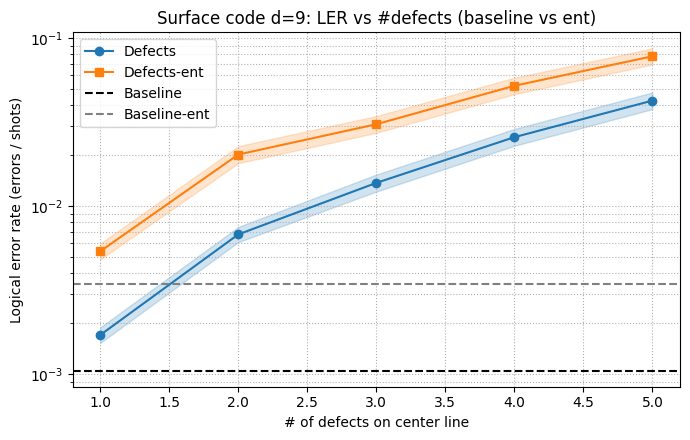

In [42]:
# ---- helpers for metadata
def get_meta(s):
    m = getattr(s, "json_metadata", None)
    if m is None:
        t = getattr(s, "task", None)
        m = getattr(t, "metadata", {}) if t is not None else {}
    return m or {}

def series_of(s):   return get_meta(s).get("series", "defect")
def ndef_of(s):
    v = get_meta(s).get("ndefects", None)
    try: return int(v) if v is not None else None
    except: return None

def to_int(x):
    try: return int(x)
    except Exception: return 0

# ---- split
baseline_stats      = [s for s in stats if series_of(s) == "baseline"]
baseline_ent_stats  = [s for s in stats if series_of(s) == "baseline_ent"]
defect_stats        = [s for s in stats if series_of(s) == "defect"      and ndef_of(s) is not None]
defect_ent_stats    = [s for s in stats if series_of(s) == "defect_ent"  and ndef_of(s) is not None]

defect_stats     = sorted(defect_stats,     key=ndef_of)
defect_ent_stats = sorted(defect_ent_stats, key=ndef_of)

# ---- baseline values
def ler_of(s): return to_int(s.errors) / max(1, to_int(s.shots))

baseline_ler     = ler_of(baseline_stats[0])     if baseline_stats else None
baseline_ent_ler = ler_of(baseline_ent_stats[0]) if baseline_ent_stats else None

# ---- plot
fig, ax = plt.subplots(figsize=(7, 4.5))

# Defects (original)
sinter.plot_error_rate(
    ax=ax,
    stats=defect_stats,
    x_func=lambda s: ndef_of(s),
    failure_values_func=lambda s: to_int(s.errors),
    failure_units_per_shot_func=lambda s: 1,  # IMPORTANT
    group_func=lambda s: None,
    filter_func=lambda s: True,
    plot_args_func=lambda i, g, gs: dict(marker="o", linestyle="-", color="C0", label="Defects" if i==0 else None),
    # line_fits=(),
    point_label_func=lambda s: None,
)

# Defects after C++ pass
if defect_ent_stats:
    sinter.plot_error_rate(
        ax=ax,
        stats=defect_ent_stats,
        x_func=lambda s: ndef_of(s),
        failure_values_func=lambda s: to_int(s.errors),
        failure_units_per_shot_func=lambda s: 1,
        group_func=lambda s: None,
        filter_func=lambda s: True,
        plot_args_func=lambda i, g, gs: dict(marker="s", linestyle="-", color="C1", label="Defects-ent" if i==0 else None),
        # line_fits=(),
        point_label_func=lambda s: None,
    )

# Baseline horizontals
if baseline_ler is not None:
    ax.axhline(y=baseline_ler, color="black", linestyle="--", linewidth=1.5, label="Baseline")

if baseline_ent_ler is not None:
    ax.axhline(y=baseline_ent_ler, color="gray", linestyle="--", linewidth=1.5, label="Baseline-ent")

ax.set_xlabel("# of defects on center line")
ax.set_ylabel("Logical error rate (errors / shots)")
ax.set_yscale("log")
ax.set_title(f"Surface code d={d}: LER vs #defects (baseline vs ent)")
ax.grid(True, which="both", ls=":")
ax.legend()
plt.tight_layout()
plt.show()